# Indexing Wikipedia
// Written on **September 24th, 2018** <br/>
// Status: **Under Development**

Goal: Index Wikipedia articles from a search query using wikidata.

Plan:
- [x] Scrape a decent amount of wikipedia articles to build small stop word repo.
- [x] Represent pages as a bag of words, search queries should target top words (excluding stop words)
- [ ] Create a table of the headers: \[word, url, weight\] using values from `StopWord.values()`
- [ ] Wrap with API, create a wikipedia search engine page at `beta.pengra.io`

In [1]:
# scraping
import requests

# NLP
from nltk.tokenize.nist import NISTTokenizer

## Creating a list of "tags" for a Wikipedia article

`StopWord` is a "bag of words" that counts two things: how many articles use a given word and how frequently it's used. This allows me to build a list of "Stop words," a list of words that poorly the context of a wikipedia article because of how often it shows up. Thus, when getting the "bag of words" of any other article, words in the `StopWord`'s bag can be removed from that article. This results in a bag of words that describe the article in a meaningful way.

In [2]:
def query_wiki(wiki_id):
    response = requests.get("https://data.pengra.io/wikibags/{}/".format(wiki_id))
    try:
        return response.json()
    except:
        return {'bag': {}}

def get_random_articles(limit):
    response = requests.get("https://en.wikipedia.org/w/api.php?action=query&list=random&rnlimit={limit}&rnnamespace=0&format=json".format(limit=limit))
    return [random['id'] for random in response.json()['query']['random']]
    

class StopWord():
    
    def __init__(self, iterable, word_threshold=0.0003, article_threshold=0.85):
        self._history = []
        self._stopwords = {}
        self._total = 0
        self._total_articles = 0
        self.word_threshold = word_threshold
        self.article_threshold = article_threshold
        self.feed(iterable)
        
    def feed(self, iterable):
        for word in iterable:
            if word not in self._history and word != '_random':
                self._history.append(word)
                bag = query_wiki(word)['bag']
                self._total_articles += 1
                for token, count in bag.items():
                    self._stopwords.setdefault(token, {"words": 0, "articles": 0})
                    self._stopwords[token]['words'] += count
                    self._stopwords[token]['articles'] += 1
                    self._total += count
        
    def sort(self, by_words=True):
        if by_words:
            self._stopwords = {
                token: count for token, count in sorted(self._stopwords.items(), key=lambda x: -x[1]['words'])
            }
        else:
            self._stopwords = {
                token: count for token, count in sorted(self._stopwords.items(), key=lambda x: -x[1]['articles'])
            }
        
    def values(self, by_words=True):
        self.sort(by_words)
        stopwords = []
        if by_words:
            threshold = self._total * self.word_threshold
        else:
            threshold = self._total_articles * self.article_threshold
        for token, counts in self._stopwords.items():
            if by_words and counts['words'] >= threshold:
                stopwords.append((token, counts['words'] / self._total))
            elif not by_words and counts['articles'] >= threshold:
                stopwords.append((token, counts['articles'] / self._total_articles))
            else:
                break
        return stopwords
        
    def clean_bag(self, word, by_words=True):
        response = query_wiki(word)
        bag = response['bag']
        word_count = response['bag_size']
        for word, percentage in self.values(by_words):
            if word in bag:
                del bag[word]
        for word, value in bag.items():
            bag[word] = value / word_count
            
        return bag

# Feeding `StopWord`s

First, `StopWord` is populated with some articles of my liking, then populated with 200 more wikipedia articles (Enough to get a general sense of word usage). The values output shows a list of words and their frequency of usage as a percentage.

For instance, take the top 5 non-character words: "the", "of", "and", "in" and "a". According to the initial scrape below, these words combined make up 11.4% of all words analyzed. This could potentially (I haven't been formally trained in stats yet) imply that the english used on wikipedia is ~11.4% these words. Cross referencing this with [google ngram](https://books.google.com/ngrams/interactive_chart?content=the%2Cof%2Cand%2Cin%2Ca&case_insensitive=on&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=&direct_url=t4%3B%2Cthe%3B%2Cc0%3B%2Cs0%3B%3Bthe%3B%2Cc0%3B%3BThe%3B%2Cc0%3B.t1%3B%2Cof%3B%2Cc0%3B.t4%3B%2Cand%3B%2Cc0%3B%2Cs0%3B%3Band%3B%2Cc0%3B%3BAnd%3B%2Cc0%3B.t4%3B%2Cin%3B%2Cc0%3B%2Cs0%3B%3Bin%3B%2Cc0%3B%3BIn%3B%2Cc0%3B.t4%3B%2Ca%3B%2Cc0%3B%2Cs0%3B%3Ba%3B%2Cc0%3B%3BA%3B%2Cc0) yields some similarity in data.

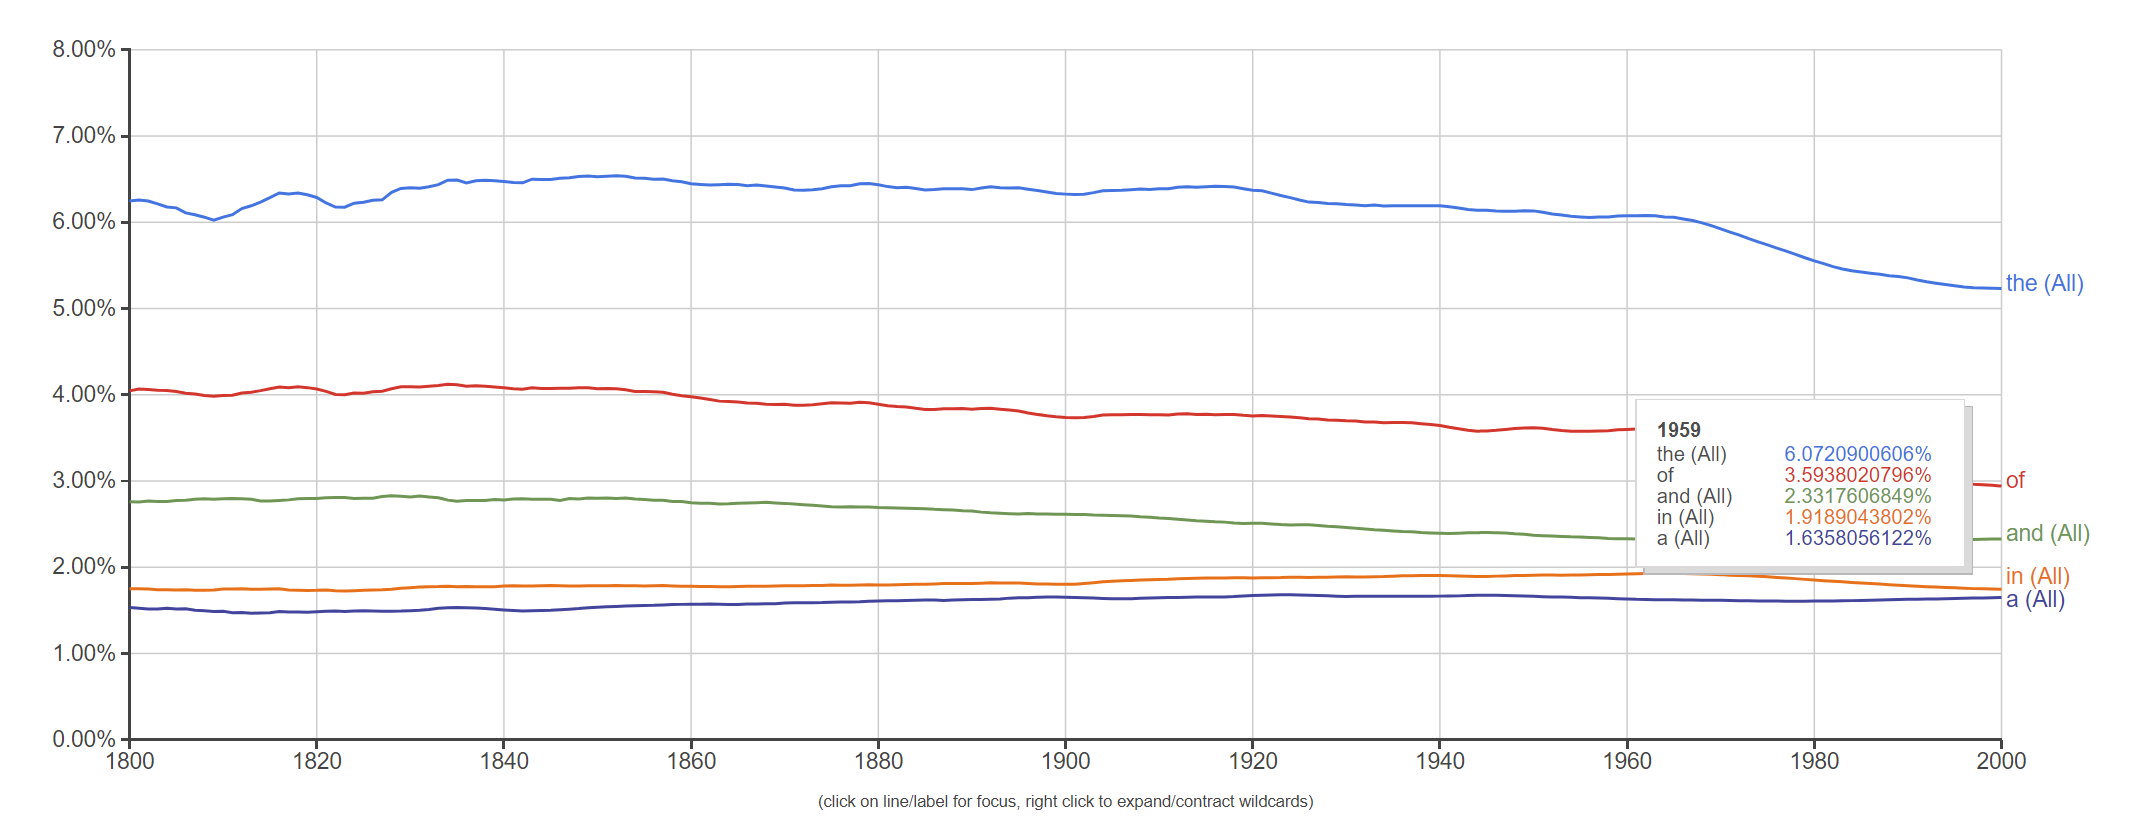

In [5]:
# Starting Pages Example
words = StopWord([
    "neural network", 
    "Hilbert_space", 
    "Divisor", 
    "Didactic_method", 
    "Saunders_Mac_Lane", 
    "Password", 
    "Lambda_calculus",
    "Mathematical_constant",
    "Riemann_zeta_function",
    "Continuous_function",
    "logic",
    "Neptune",
    "Black_hole",
    "Alan_Turing",
    "War"
])

for x in range(2):
    words.feed(get_random_articles(100))

words.values()

[('the', 0.05816226525044367),
 (',', 0.046391015283553626),
 ('.', 0.04038884327073345),
 ('of', 0.031022700182766934),
 ('and', 0.021306916006674965),
 ('in', 0.020962572510793843),
 ('a', 0.020194421635366725),
 ('to', 0.01987656610070723),
 ('is', 0.011840118666066273),
 ('(', 0.010558101342939634),
 (')', 0.010558101342939634),
 ('was', 0.0087251344264032),
 ('for', 0.008677456096204276),
 ('that', 0.008333112600323152),
 ('as', 0.007570259317140359),
 ('"', 0.007024607315974889),
 ('on', 0.0066537758588721425),
 ('by', 0.006076338304240723),
 ('with', 0.005737292400603926),
 ('at', 0.0047731306121367835),
 ('he', 0.00468307154398326),
 ('it', 0.004624798029295685),
 ('be', 0.004338728048102138),
 ('from', 0.004248668979948613),
 ('an', 0.0041903954652610384),
 ('x', 0.00407384843588589),
 ('are', 0.0038566471538685667),
 ('his', 0.0038566471538685667),
 ('\\', 0.003750695308982068),
 ('this', 0.0033109951527030964),
 ('{', 0.003003734802532249),
 ('}', 0.003003734802532249),
 ('w

# Words by Article Frequency

Alternatively, words can be analyzed by how often they appear in articles. For instance, the word "the" appears in 89.3% of all articles. 

In [6]:
words.values(by_words=False)

[('.', 0.9116279069767442),
 ('the', 0.8930232558139535),
 ('in', 0.8558139534883721),
 ('a', 0.8558139534883721)]

# Populating the Server

The simple endpoint I set up [`data.pengra.io/wikibags`](https://data.pengra.io/wikibags/) is a simple endpoint that reads a wikipedia article and turns it to a bag of words and caches the results. This helps populate the server and redueces DOSing wikipedia.

In [167]:
def get_random_articles(limit):
    response = requests.get("https://en.wikipedia.org/w/api.php?action=query&list=random&rnlimit={limit}&rnnamespace=0&format=json".format(limit=limit))
    return [random['id'] for random in response.json()['query']['random']]

def populate_server(limit):
    for x in get_random_articles(limit):
        query_wiki(x)

populate_server(1000)

# Future Work
- [ ] Differentiate words between header tags (such as `h1`, `header`, `title`, etc) and body tags
- [ ] Categorize different stop words between different subjects
